In [12]:
import os

# Remove any preset backend
os.environ.pop("MPLBACKEND", None)

import matplotlib

# Choose a non‑interactive file backend (you can switch to "TkAgg" if you want pop‑up windows)
matplotlib.use("agg")

from matplotlib.gridspec import GridSpec

import matplotlib.image as mpimg
from neuromaps import transforms
from matplotlib.gridspec import GridSpec
import pandas as pd
from gradec.utils import _zero_medial_wall
import nibabel as nib
from nilearn.plotting.cm import _cmap_d as nilearn_cmaps
from surfplot import Plot
from nilearn import datasets
from gradec.plot import plot_radar, plot_cloud
from gradec.fetcher import _fetch_features, _fetch_frequencies, _fetch_classification
from gradec.utils import _decoding_filter
from nimare.decode.continuous import CorrelationDecoder
import numpy as np
from nilearn.maskers import NiftiMasker
from nilearn.image import threshold_img, index_img
from neuromaps.datasets import fetch_fslr
from nimare.transforms import p_to_z
from nilearn.plotting import plot_stat_map
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import nilearn.reporting

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from nilearn import datasets, plotting, image

In [14]:
CMAP = nilearn_cmaps["cold_hot"]
CMAP = "Spectral_r"

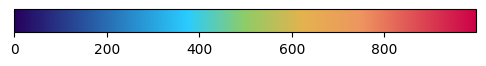

In [15]:

# Define the number of colors in the colormap
num_colors = 1000

# Define anchor points for key colors using hex values
colors = [
    "#26005c",  # Dark Blue
    "#274492",
    "#2888c9",
    "#29ccff",  # light blue
    "#8FCC66",  # green
    "#e4b24e",  # Yellow (adjusted)
    "#ee955f",  # Orange
    "#dd4a53",  # Orange
    "#cc0047",  # Red
]

# Create a smooth interpolation for the custom colormap
cmap1 = LinearSegmentedColormap.from_list("custom_cmap", colors, N=num_colors)

# Plot the color gradient
plt.figure(figsize=(8, 2))
plt.imshow([list(range(num_colors))], aspect="auto", cmap=cmap1)
plt.gca().set_visible(False)
plt.colorbar(orientation="horizontal")
plt.show()

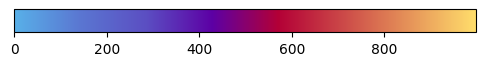

In [16]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Define the number of colors in the colormap
num_colors = 1000

# Define anchor points for key colors using hex values
colors = [
    "#58b0e8",  # light blue
    "#5a76d1",
    "#5b4ec2",
    "#5c00a4",  # purple
    "#b30036",  # Red
    "#cc4a48",  # Orange
    "#e69459",  # Orange
    "#ffde6b",  # Yellow (adjusted)
]

# Create a smooth interpolation for the custom colormap
cmap2 = LinearSegmentedColormap.from_list("custom_cmap", colors, N=num_colors)

# Plot the color gradient
plt.figure(figsize=(8, 2))
plt.imshow([list(range(num_colors))], aspect="auto", cmap=cmap2)
plt.gca().set_visible(False)
plt.colorbar(orientation="horizontal")
plt.show()

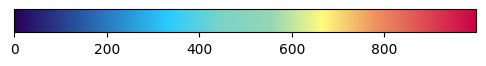

In [17]:
# Define anchor points for key colors using hex values
colors = [
    "#26005c",  # Dark Blue
    "#274492",
    "#2888c9",
    "#29ccff",  # light blue
    "#79d3c8",  # green
    "#94d6b5",
    "#fffb7d",  # Yellow (adjusted)
    "#ee955f",  # Orange
    "#dd4a53",  # Orange
    "#cc0047",  # Red
]

# Create a smooth interpolation for the custom colormap
cmap3 = LinearSegmentedColormap.from_list("custom_cmap", colors, N=num_colors)

# Plot the color gradient
plt.figure(figsize=(8, 2))
plt.imshow([list(range(num_colors))], aspect="auto", cmap=cmap3)
plt.gca().set_visible(False)
plt.colorbar(orientation="horizontal")
plt.show()

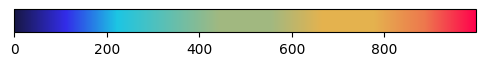

In [18]:
# Define anchor points for key colors using hex values
colors = [
    "#171744",  # Dark Blue
    "#322ce8",
    "#1cc5e3",  # light blue
    "#5fbfb1",
    "#a1b880",
    "#a1b880",
    "#E4B24E",  # Yellow (adjusted)
    "#E4B24E",  # Yellow (adjusted)
    "#ed774d",  # Orange
    # "#f63b4d",  # Orange
    "#ff004c",  # Red
]
# Create a smooth interpolation for the custom colormap
cmap4 = LinearSegmentedColormap.from_list("custom_cmap", colors, N=num_colors)

# Plot the color gradient
plt.figure(figsize=(8, 2))
plt.imshow([list(range(num_colors))], aspect="auto", cmap=cmap4)
plt.gca().set_visible(False)
plt.colorbar(orientation="horizontal")
plt.show()

In [19]:
def trim_image(img=None, tol=1, fix=True):
    if fix:
        mask = img != tol
    else:
        mask = img <= tol
    if img.ndim == 3:
        mask = mask.any(2)
    mask0, mask1 = mask.any(0), mask.any(1)
    return img[np.ix_(mask1, mask0)]

In [20]:
def plot_vol(
    nii_img_thr, threshold, mask_contours=None, vmax=6, alpha=1, cmap=CMAP, dim=-0.45
):
    template = datasets.load_mni152_template(resolution=1)

    display_modes = ["x", "y", "z"]
    fig = plt.figure(figsize=(5, 5))
    fig.subplots_adjust(
        left=None, bottom=None, right=None, top=None, wspace=None, hspace=None
    )
    gs = GridSpec(2, 2, figure=fig)

    for dsp_i, display_mode in enumerate(display_modes):
        if display_mode == "z":
            ax = fig.add_subplot(gs[:, 1], aspect="equal")
            colorbar = True
        else:
            ax = fig.add_subplot(gs[dsp_i, 0], aspect="equal")
            colorbar = False

        display = plot_stat_map(
            nii_img_thr,
            bg_img=template,
            black_bg=False,
            draw_cross=False,
            annotate=True,
            alpha=alpha,
            cmap=cmap,
            threshold=threshold,
            colorbar=colorbar,
            display_mode=display_mode,
            cut_coords=1,
            vmax=vmax,
            axes=ax,
            dim=dim,  # Adjusted dimming factor
        )
        if mask_contours:
            display.add_contours(mask_contours, levels=[0.5], colors="black")

    return fig

In [21]:
def plot_vol2(
    nii_img_thr, threshold, mask_contours=None, vmax=6, alpha=1, cmap=CMAP, dim=-0.45
):
    template = datasets.load_mni152_template(resolution=1)

    # Create a figure with 9 subplots in a single row
    fig, axes = plt.subplots(1, 9, figsize=(27, 3))

    # Define slices for x, y, z directions
    '''slices_x = [2, 15, -4]
    slices_y = [-18, -33, -41]
    slices_z = [18, -1, 2]'''

    slices_x = [45, -54, -4]
    slices_y = [-18, -41, -41]
    slices_z = [2, -9, 2]

    # Combine all slices into a single list for easy iteration
    slices = slices_x + slices_y + slices_z
    display_modes = ["x"] * 3 + ["y"] * 3 + ["z"] * 3

    # Iterate over the slices and axes
    for i, (slice, display_mode, ax) in enumerate(zip(slices, display_modes, axes)):
        display = plot_stat_map(
            nii_img_thr,
            bg_img=template,
            display_mode=display_mode,
            cut_coords=[slice],
            black_bg=False,
            draw_cross=False,
            annotate=True,
            alpha=alpha,
            cmap=cmap,
            threshold=threshold,
            colorbar=False,  # Disable individual colorbars
            vmax=vmax,
            dim=dim,  # Adjusted dimming factor
            axes=ax,
        )

        if mask_contours:
            display.add_contours(mask_contours, levels=[0.5], colors="black")

    plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust the layout to fit the colorbar
    return fig

In [22]:
def plot_surf(nii_img_thr, mask_contours=None, vmax=8, cmap=cmap1):
    map_lh, map_rh = transforms.mni152_to_fslr(nii_img_thr, fslr_density="32k")
    map_lh, map_rh = _zero_medial_wall(
        map_lh,
        map_rh,
        space="fsLR",
        density="32k",
    )
    # midthickness

    surfaces = fetch_fslr(density="32k")
    lh, rh = surfaces["inflated"]
    sulc_lh, sulc_rh = surfaces["sulc"]

    p = Plot(surf_lh=lh, surf_rh=rh, layout="grid")
    p.add_layer({"left": sulc_lh, "right": sulc_rh}, cmap="binary_r", cbar=False)
    p.add_layer(
        {"left": map_lh, "right": map_rh},
        cmap=cmap,
        cbar=False,
        color_range=(-vmax, vmax)
    )
    if mask_contours:
        mask_lh, mask_rh = transforms.mni152_to_fslr(mask_contours, fslr_density="32k")
        mask_lh, mask_rh = _zero_medial_wall(
            mask_lh,
            mask_rh,
            space="fsLR",
            density="32k",
        )
        mask_arr_lh = mask_lh.agg_data()
        mask_arr_rh = mask_rh.agg_data()
        countours_lh = np.zeros_like(mask_arr_lh)
        countours_lh[mask_arr_lh != 0] = 1
        countours_rh = np.zeros_like(mask_arr_rh)
        countours_rh[mask_arr_rh != 0] = 1

        colors = [(0, 0, 0, 0)]
        contour_cmap = ListedColormap(colors, 'regions', N=1)
        line_cmap = ListedColormap(["black"], 'regions', N=1)
        p.add_layer(
            {"left": countours_lh, "right": countours_rh}, 
            cmap=line_cmap, 
            as_outline=True, 
            cbar=False
        )
        p.add_layer(
            {"left": countours_lh, "right": countours_rh},
            cmap=contour_cmap,
            cbar=False,
        )
    
    return p.build()

In [49]:
from nilearn import datasets

fsaverage = datasets.fetch_surf_fsaverage()
from nilearn import surface

In [24]:
MED = False
data_dir = op.join("./dset")
abide_dir = op.join(data_dir, "group-medication/habenula") if MED else op.join(data_dir, "group/habenula")
fig_dir = op.join(abide_dir, "fig-p0001redo4")
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

In [25]:
DSET, MODEL = "neuroquery", "lda"
decoding_dir = "./decoding"
decoder_fn = op.join(decoding_dir, f"{MODEL}_{DSET}_decoder.pkl.gz")

decoder = CorrelationDecoder.load(decoder_fn)

features = _fetch_features(DSET, MODEL, data_dir=decoding_dir)
frequencies = _fetch_frequencies(DSET, MODEL, data_dir=decoding_dir)
classification, class_lst = _fetch_classification(DSET, MODEL, data_dir=decoding_dir)

In [26]:
mask_img = datasets.load_mni152_brain_mask(resolution=1)
masker = NiftiMasker(mask_img=mask_img)
masker = masker.fit()

In [27]:
test_dict = {
    "1s": "Group Average (One-Sample T-Test)",
    "2s": "Group Comparison (Two-Sample Unpaired T-Test: ASD-TD)",
}

/var/folders/b0/6xxmhnys7hj9g_47_dsjm7c00000gn/T/ipykernel_42108/2511071445.py:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_table is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  cluster_df = pd.read_table(cluster_fn, skiprows=8, delim_whitespace=True, names=column_names)
++ 3dcalc: AFNI version=AFNI_24.0.10 (Mar 11 2024) [64-bit]
++ Authored by: A cast of thousands


     pthr  .10000  .05000  .02000  .01000
0  0.0500  1482.6  1773.0  2163.0  2497.0
1  0.0200   518.3   623.0   768.0   880.0
2  0.0100   283.8   343.1   423.0   489.5
3  0.0050   168.3   205.7   254.7   298.3
4  0.0020    93.8   113.8   141.8   168.5
5  0.0010    62.3    76.7    97.0   116.7
6  0.0005    43.1    53.9    67.7    79.7
7  0.0002    27.0    33.7    44.0    53.0
8  0.0001    18.9    24.4    31.8    38.8


++ Output dataset ././dset/group/habenula/sub-group_task-rest_desc-2SampletTest_zmaptest0001.nii.gz


38.8 0.0001 3.890591886413094


/Users/chloehampson/Desktop/projects/abide-analysis/.venv/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/Users/chloehampson/Desktop/projects/abide-analysis/.venv/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/Users/chloehampson/Desktop/projects/abide-analysis/.venv/lib/python3.9/site-packages/nilearn/reporting/_get_clusters_table.py:339: UserWarning: Attention: No clusters with stat lower than -3.890591886413094
  warnings

  Cluster ID     X     Y     Z  Peak Stat Cluster Size (mm3)
0          1  59.5 -38.5  -0.5   5.402785               1256
1         1a  47.5 -40.5   3.5   4.879167                   
2         1b  69.5 -38.5  -0.5   4.619359                   
3          2 -52.5 -24.5  -2.5   4.930276               1160
4         2a -60.5 -28.5   3.5   4.642123                   
5         2b -60.5 -30.5  -4.5   4.306325                   
6          3 -60.5 -12.5  35.5   4.861617                480


/var/folders/b0/6xxmhnys7hj9g_47_dsjm7c00000gn/T/ipykernel_42108/2390743035.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust the layout to fit the colorbar


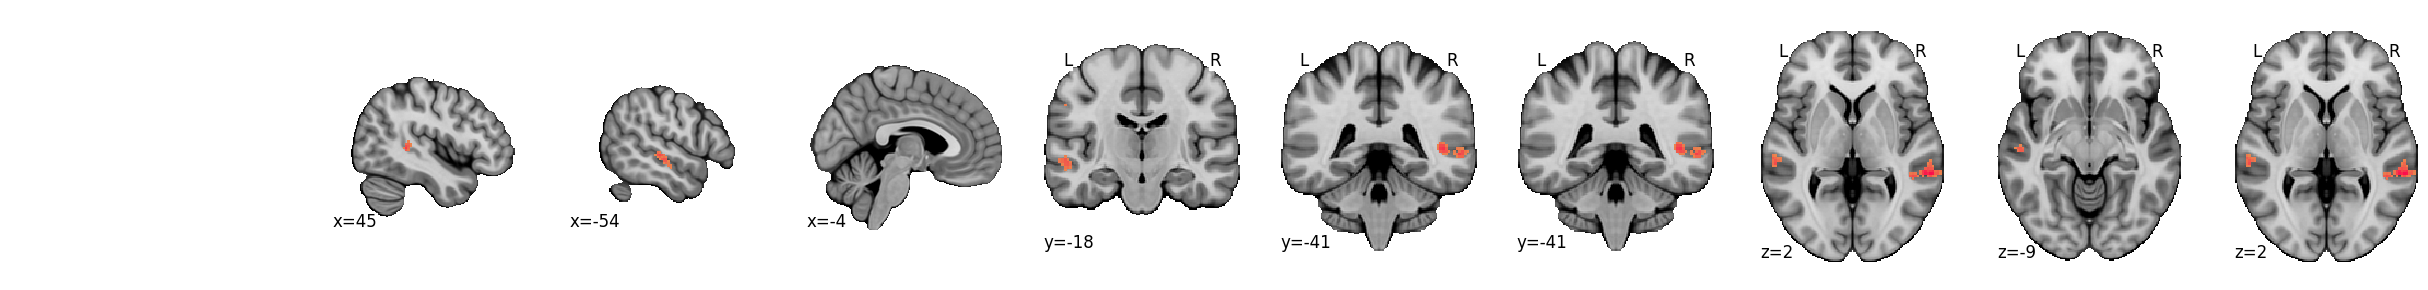

: 

In [56]:
brik_fn = op.join(abide_dir, "sub-group_task-rest_desc-1S2StTesthabenula_briks+tlrc.BRIK")
table_fn = op.join(abide_dir, "sub-group_task-rest_desc-1S2StTesthabenula_table.txt")
nii_1s_fn = op.join(abide_dir, "sub-group_task-rest_desc-1SampletTest_zmap0001.nii.gz")
nii_2s_fn = op.join(abide_dir, "sub-group_task-rest_desc-2SampletTest_zmaptest0001.nii.gz")
cluster_fn = op.join(
    abide_dir, "clustsim", "clustsim_out.NN2_2sided.1D"
)

column_names = [".10000", ".05000", ".02000", ".01000"]
cluster_df = pd.read_table(cluster_fn, skiprows=8, delim_whitespace=True, names=column_names)
cluster_df = cluster_df.reset_index()
cluster_df.rename(columns={'index': 'pthr'}, inplace=True)
print(cluster_df)


brik_idx = [9, 11] if MED else [8, 10]
nii_fns = [nii_1s_fn, nii_2s_fn]
tests = ["1s", "2s"]
alpha = ".01000"
pthrs = [0.0001, 0.0001]
cohen_thresh = 0

data_df = pd.read_csv(table_fn, sep="\t")
n_sub = data_df.groupby("group").size().sum()
n_sub_1, n_sub_2 = data_df.groupby("group").size().values

for brik_i, nii_fn, test, pthr in zip(brik_idx, nii_fns, tests, pthrs):
    if test == "1s":
        # Skip the entire loop iteration for the "2s" test
        continue

    '''if test == "1s":
        # continue
        convert = f"3dAFNItoNIFTI \
            -prefix {nii_fn} \
            {brik_fn}[{brik_i}]"
        os.system(convert)

    elif test == "2s":
        convert = f"3dcalc -a {brik_fn}'[{brik_i}]' -expr '-1*a' -prefix {nii_fn}"
        os.system(convert)'''

    nii_img = nib.load(nii_fn)
    z_thresh = p_to_z(pthr)

    clust_ext = cluster_df.loc[cluster_df["pthr"] == pthr, alpha].values[0]
    nii_thr_img = threshold_img(nii_img, z_thresh, cluster_threshold=clust_ext)
    print(clust_ext, pthr, z_thresh)

    nii_arr = masker.transform(nii_img)
    if test == "1s":
        nii_cohen_arr = nii_arr / np.sqrt(n_sub)
    elif test == "2s":
        nii_cohen_arr = nii_arr / (np.sqrt(n_sub_1) + np.sqrt(n_sub_2))

    nii_cohen_img = masker.inverse_transform(nii_cohen_arr)

    nii_thr_arr = masker.transform(nii_thr_img)
    nii_contour_arr = np.zeros_like(nii_thr_arr)
    nii_contour_arr[(nii_thr_arr > z_thresh) | (nii_thr_arr < -z_thresh)] = 1
    nii_contour_img = masker.inverse_transform(nii_contour_arr)
    nii_contour_img_3d = index_img(nii_contour_img, 0)

    vmax = round(np.max(np.abs(nii_thr_arr)), 2)
    vmax = 13 if vmax > 13 else vmax
    # c_vmax = round(np.max(np.abs(nii_cohen_arr)), 2)
    c_vmax = 0.1 if test == "2s" else 0.3

    clusters = nilearn.reporting.get_clusters_table(
        nii_thr_img, z_thresh, two_sided=True
    )
    print(clusters)  # coordinates are same as affine of input (MNI)'''

    nib.save(nii_thr_img, op.join(abide_dir, f"{test}_thresh-0001_zmap.nii.gz"))

    '''stat_fig = plot_vol(nii_thr_img, z_thresh, vmax=vmax, cmap=cmap4)
    vol_fig = plot_vol(nii_thr_img, z_thresh, vmax=vmax, cmap=cmap4)
    cohen_fig = plot_vol(
        nii_cohen_img,
        cohen_thresh,
        mask_contours=nii_contour_img_3d,
        vmax=c_vmax,
        alpha=0.8,
        cmap=cmap4,
    )'''

    vol2_fig = plot_vol2(nii_thr_img, z_thresh, vmax=vmax, cmap=cmap4)
    '''cohen2_fig = plot_vol2(
        nii_cohen_img,
        cohen_thresh,
        mask_contours=nii_contour_img_3d,
        vmax=c_vmax,
        alpha=0.8,
        cmap=cmap4,
    )

    surf_fig = plot_surf(nii_thr_img, vmax=vmax, cmap=cmap4)'''
    
    plt.show(vol2_fig)

    '''cohen_surf_fig = plot_surf(
        nii_cohen_img, mask_contours=nii_contour_img_3d, vmax=c_vmax, cmap=cmap4
    )

    if test == "1s":
        nii_pos_arr = np.where(nii_arr > 0, nii_arr, 0)
        img_to_decode = masker.inverse_transform(nii_pos_arr)
    elif test == "2s":
        nii_neg_arr = abs(np.where(nii_arr > 0, nii_arr, 0))
        img_to_decode = masker.inverse_transform(nii_neg_arr)

    corrs_df = decoder.transform(img_to_decode)
    num_val = [int(lab.split("__")[1].split("_")[0]) for lab in corrs_df.index.to_list()]
    indices = np.argsort(num_val)
    corrs_df = corrs_df.iloc[indices]
    filtered_df, filtered_features, filtered_frequencies = _decoding_filter(
        corrs_df,
        features,
        classification,
        freq_by_topic=frequencies,
        class_by_topic=class_lst,
    )'''

    # Visualize results
    '''corrs = filtered_df["r"].to_numpy()
    # Radar plot
    plot_radar(
        corrs,
        filtered_features,
        MODEL,
        cmap=cmap4,
        out_fig=op.join(fig_dir, f"{test}_radar.png"),
    )

    # Word cloud plot
    plot_cloud(
        corrs,
        filtered_features,
        MODEL,
        width=10,
        height=5,
        frequencies=filtered_frequencies,
        cmap=cmap4,
        out_fig=op.join(fig_dir, f"{test}_wordcloud.png"),
    )
    # plt.show(stat_fig)

    stat_fig.savefig(
        op.join(fig_dir, f"{test}_stat.png"), bbox_inches="tight", dpi=300
    )'''
    '''vol_fig.savefig(op.join(fig_dir, f"{test}_volume.png"), bbox_inches="tight", dpi=300)
    cohen_fig.savefig(op.join(fig_dir, f"{test}_volume-cohen.png"), bbox_inches="tight", dpi=300)
    surf_fig.savefig(op.join(fig_dir, f"{test}_surface.png"), bbox_inches="tight", dpi=300)
    cohen_surf_fig.savefig(op.join(fig_dir, f"{test}_surface-cohen.png"), bbox_inches="tight", dpi=300)
    vol2_fig.savefig(
        op.join(fig_dir, f"{test}_volume2.png"), bbox_inches="tight", dpi=300
    )
    cohen2_fig.savefig(
        op.join(fig_dir, f"{test}_volume-cohen2.png"), bbox_inches="tight", dpi=300
    )'''

## Combine sub-figures

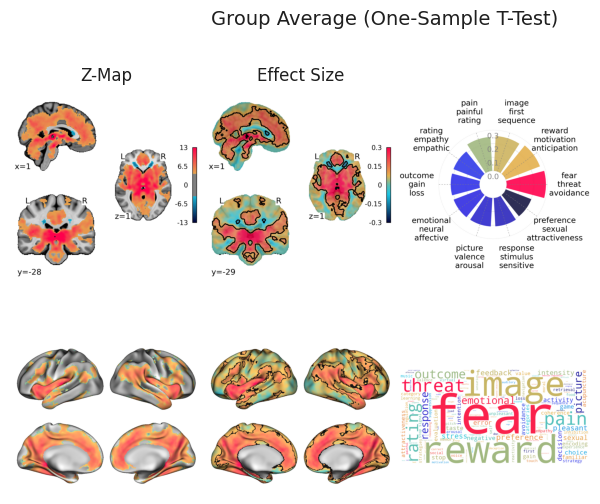

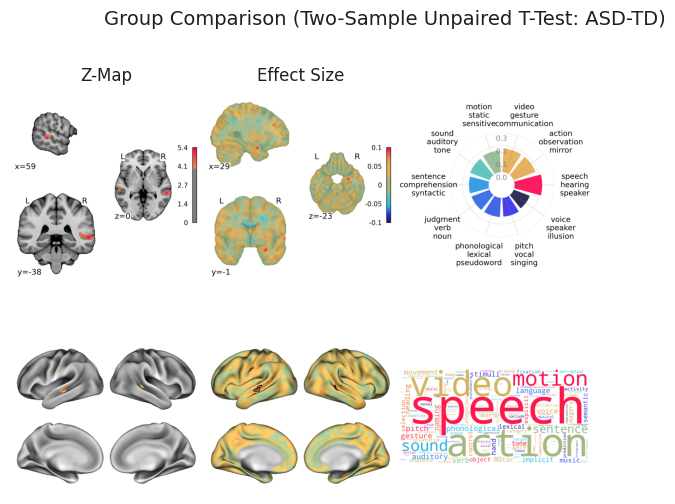

In [29]:
for test in tests:
    output_file = op.join(fig_dir, f"0_{test}.png")

    figure1 = plt.figure(figsize=(10, 6))
    gs = GridSpec(
        nrows=2, ncols=4, figure=figure1
    )  # Increase columns to 4 for better spacing

    for col, data_type in enumerate(["", "-cohen"]):
        img_files = [
            op.join(fig_dir, f"{test}_volume{data_type}.png"),
            op.join(fig_dir, f"{test}_surface{data_type}.png"),
        ]

        for row, fn in enumerate(img_files):
            img1 = mpimg.imread(fn)
            # if row == 0:
            #    img1 = trim_image(img=img1, tol=1, fix=True)

            ax = figure1.add_subplot(gs[row, col], aspect="equal")
            ax.imshow(img1)

            if col == 0 and row == 0:
                ax.set_title("Z-Map", fontsize=12)
            if col == 1 and row == 0:
                ax.set_title("Effect Size", fontsize=12)
            ax.set_axis_off()

    # Radar plot in column 3, row 1
    radar_fn = op.join(fig_dir, f"{test}_radar.png")
    radar_img = mpimg.imread(radar_fn)
    ax = figure1.add_subplot(gs[0, 2], aspect="equal")
    ax.imshow(radar_img)
    ax.set_axis_off()

    # Word cloud in column 3, row 2
    dec_fn = op.join(fig_dir, f"{test}_wordcloud.png")
    img1 = mpimg.imread(dec_fn)
    ax = figure1.add_subplot(gs[1, 2], aspect="equal")
    ax.imshow(img1)
    ax.set_axis_off()

    figure1.suptitle(test_dict[test], fontsize=14)
    figure1.subplots_adjust(wspace=0.01, hspace=0.001)
    figure1.savefig(output_file, bbox_inches="tight", dpi=300)
    plt.show()

In [30]:
import os
import subprocess
import pandas as pd
import nibabel as nib
import numpy as np
from nilearn.image import threshold_img
from nilearn.reporting import get_clusters_table


# Function to execute the AFNI whereami command and parse its output
def find_region(coord):
    # Format the coordinates properly for the whereami command
    coord_str = f"{coord[0]} {coord[1]} {coord[2]}"
    # Command to query AFNI's whereami
    whereami_cmd = f"whereami [{coord_str}] -atlas MNI_Glasser_HCP_v1.0 -classic"
    try:
        result = subprocess.run(
            whereami_cmd,
            shell=True,
            check=True,
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
            text=True,
        )
        output = result.stdout
        # Print the full output for debugging purposes
        print(f"whereami output for {coord}:")
        print(output)
        # Parse the output to extract the region name
        for line in output.split("\n"):
            if "Focus point (LPI)" in line:
                parts = line.split()
                if len(parts) > 3:
                    return parts[3]  # Extract the region name
        return "Unknown"
    except subprocess.CalledProcessError as e:
        print(
            f"Error running whereami command: {e}\nOutput: {e.output}\nError: {e.stderr}"
        )
        return "Unknown"


# Extract the coordinates from the clusters table and map to regions
def map_clusters_to_regions(clusters_df):
    coordinates = clusters_df[["X", "Y", "Z"]].values
    regions = [find_region(coord) for coord in coordinates]
    clusters_df["Region"] = regions
    return clusters_df


# Iterate over your clusters and map to regions
for brik_i, nii_fn, test, pthr in zip(brik_idx, nii_fns, tests, pthrs):
    convert = f"3dAFNItoNIFTI -prefix {nii_fn} {brik_fn}[{brik_i}]"
    os.system(convert)

    nii_img = nib.load(nii_fn)
    z_thresh = p_to_z(pthr)
    info = nii_img.get_fdata()

    clust_ext = cluster_df.loc[cluster_df["pthr"] == pthr, alpha].values[0]
    nii_thr_img = threshold_img(nii_img, z_thresh, cluster_threshold=clust_ext)

    clusters = get_clusters_table(nii_thr_img, stat_threshold=z_thresh, two_sided=True)
    clusters_with_regions = map_clusters_to_regions(clusters)


++ 3dAFNItoNIFTI: AFNI version=AFNI_24.0.10 (Mar 11 2024) [64-bit]
*+ WARNING: file ./dset/group/habenula/sub-group_task-rest_desc-1S2StTesthabenula_briks+tlrc.BRIK: fixed 40 float errors


whereami output for [ -0.5 -28.5   1.5]:
++ Input coordinates orientation set by default rules to RAI
+++++++ nearby Atlas structures +++++++

Original input data coordinates in TLRC space

Focus point (LPI)=
      0 mm [L],   28 mm [A],    2 mm [S] {TLRC}
      0 mm [L],   29 mm [A],    3 mm [S] {MNI}

Atlas MNI_Glasser_HCP_v1.0: Glasser HCP 2016 surface-based parcellation
 * Within 5 mm: L_Area_posterior_24
            -AND-  L_Area_a24
            -AND-  R_Area_a24
 * Within 6 mm: R_Area_posterior_24
            -AND-  L_Area_25
 * Within 7 mm: R_Area_25


******** Please use results with caution! ********
******** Brain anatomy is quite variable! ********
******** The database may contain errors! ********


whereami output for [ 5.5 -2.5  1.5]:
++ Input coordinates orientation set by default rules to RAI
+++++++ nearby Atlas structures +++++++

Original input data coordinates in TLRC space

Focus point (LPI)=
      0 mm [L],    2 mm [A],    2 mm [S] {TLRC}
      0 mm [L],    2 mm [

++ 3dAFNItoNIFTI: AFNI version=AFNI_24.0.10 (Mar 11 2024) [64-bit]
/Users/chloehampson/Desktop/projects/abide-analysis/.venv/lib/python3.9/site-packages/nilearn/reporting/_get_clusters_table.py:339: UserWarning: Attention: No clusters with stat higher than 3.890591886413094
  warnings.warn(


whereami output for [ 59.5 -38.5  -0.5]:
++ Input coordinates orientation set by default rules to RAI
+++++++ nearby Atlas structures +++++++

Original input data coordinates in TLRC space

Focus point (LPI)=
      0 mm [L],   38 mm [A],   -0 mm [I] {TLRC}
      0 mm [L],   40 mm [A],    2 mm [S] {MNI}

Atlas MNI_Glasser_HCP_v1.0: Glasser HCP 2016 surface-based parcellation
   Focus point:  R_Area_a24
 * Within 1 mm: L_Area_posterior_24
 * Within 3 mm: L_Area_a24
 * Within 4 mm: R_Area_posterior_24


******** Please use results with caution! ********
******** Brain anatomy is quite variable! ********
******** The database may contain errors! ********


whereami output for [ 47.5 -40.5   3.5]:
++ Input coordinates orientation set by default rules to RAI
+++++++ nearby Atlas structures +++++++

Original input data coordinates in TLRC space

Focus point (LPI)=
      0 mm [L],   40 mm [A],    4 mm [S] {TLRC}
      0 mm [L],   42 mm [A],    6 mm [S] {MNI}

Atlas MNI_Glasser_HCP_v1.0: Glasse

In [31]:
from nilearn import datasets
from nilearn.image import load_img
from nilearn.input_data import NiftiLabelsMasker
import numpy as np

# Load the Juelich atlas
juelich_atlas = datasets.fetch_atlas_juelich("maxprob-thr0-1mm")
atlas_filename = juelich_atlas.maps
atlas_labels = juelich_atlas.labels

# Load the Harvard-Oxford atlas
harvard_oxford_atlas = datasets.fetch_atlas_harvard_oxford("sub-maxprob-thr25-1mm")
atlas_filename = harvard_oxford_atlas.maps
atlas_labels = harvard_oxford_atlas.labels

# Load the atlas image
atlas_img = load_img(atlas_filename)


# Function to find the region for a given coordinate
def find_region(coord):
    # Transform MNI coordinates to voxel indices
    voxel_indices = np.round(
        nib.affines.apply_affine(np.linalg.inv(atlas_img.affine), coord)
    ).astype(int)
    # Get the label index for the voxel
    label_idx = atlas_img.get_fdata()[tuple(voxel_indices)]
    region_name = (
        atlas_labels[int(label_idx)]
        if int(label_idx) < len(atlas_labels)
        else "Unknown"
    )
    return region_name


# Extract the coordinates from the clusters table and map to regions
def map_clusters_to_regions(clusters_df):
    coordinates = clusters_df[["X", "Y", "Z"]].values
    regions = [find_region(coord) for coord in coordinates]
    clusters_df["Region"] = regions
    return clusters_df


# Iterate over your clusters and map to regions
for brik_i, nii_fn, test, pthr in zip(brik_idx, nii_fns, tests, pthrs):
    convert = f"3dAFNItoNIFTI -prefix {nii_fn} {brik_fn}[{brik_i}]"
    os.system(convert)

    nii_img = nib.load(nii_fn)
    z_thresh = p_to_z(pthr)
    info = nii_img.get_fdata()

    clust_ext = cluster_df.loc[cluster_df["pthr"] == pthr, alpha].values[0]
    nii_thr_img = threshold_img(nii_img, z_thresh, cluster_threshold=clust_ext)
    print(clust_ext, pthr, z_thresh)

    clusters = nilearn.reporting.get_clusters_table(
        nii_thr_img, stat_threshold=z_thresh, two_sided=True
    )
    clusters_with_regions = map_clusters_to_regions(clusters)
    print(clusters_with_regions)

    output_filename = op.join(abide_dir, f"clusters_with_subregions_{test}_pthr_{pthr}.csv")
    clusters_with_regions.to_csv(output_filename, index=False)
    print(f"Saved clusters with regions to {output_filename}")




++ 3dAFNItoNIFTI: AFNI version=AFNI_24.0.10 (Mar 11 2024) [64-bit]
*+ WARNING: file ./dset/group/habenula/sub-group_task-rest_desc-1S2StTesthabenula_briks+tlrc.BRIK: fixed 40 float errors


38.8 0.0001 3.890591886413094
   Cluster ID     X     Y     Z  Peak Stat Cluster Size (mm3)  \
0           1  -0.5 -28.5   1.5  38.277458             645336   
1          1a   5.5  -2.5   1.5  17.070114                      
2          1b  13.5 -30.5  -4.5  15.703444                      
3          1c  -0.5 -22.5 -18.5  14.814359                      
4           2 -28.5  33.5  25.5   6.612488               3728   
5          2a -24.5  23.5  41.5   5.389577                      
6          2b -32.5  39.5  33.5   5.230610                      
7          2c -28.5  35.5  39.5   5.091123                      
8           3  25.5  31.5  39.5   6.094035               3536   
9          3a  31.5  37.5  25.5   5.589732                      
10         3b  21.5  31.5  45.5   5.528059                      
11         3c  37.5  31.5  31.5   5.076546                      
12          4 -32.5 -56.5  43.5   6.044006                936   
13          5 -20.5 -44.5  71.5   5.870116                48

++ 3dAFNItoNIFTI: AFNI version=AFNI_24.0.10 (Mar 11 2024) [64-bit]


38.8 0.0001 3.890591886413094


/Users/chloehampson/Desktop/projects/abide-analysis/.venv/lib/python3.9/site-packages/nilearn/reporting/_get_clusters_table.py:339: UserWarning: Attention: No clusters with stat higher than 3.890591886413094
  warnings.warn(


  Cluster ID     X     Y     Z  Peak Stat Cluster Size (mm3)  \
0          1  59.5 -38.5  -0.5  -5.402785               1256   
1         1a  47.5 -40.5   3.5  -4.879167                      
2         1b  69.5 -38.5  -0.5  -4.619359                      
3          2 -52.5 -24.5  -2.5  -4.930276               1160   
4         2a -60.5 -28.5   3.5  -4.642123                      
5         2b -60.5 -30.5  -4.5  -4.306325                      
6          3 -60.5 -12.5  35.5  -4.861617                480   

                   Region  
0  Right Cerebral Cortex   
1  Right Cerebral Cortex   
2  Right Cerebral Cortex   
3   Left Cerebral Cortex   
4   Left Cerebral Cortex   
5   Left Cerebral Cortex   
6   Left Cerebral Cortex   
Saved clusters with regions to ./dset/group/habenula/clusters_with_subregions_2s_pthr_0.0001.csv


In [32]:
# plot age and phenotype coordinates together
coordinates_pheno = {
    "1": [[47.5, -40.5, 3.5], [69.5, -38.5, -0.5]],
    "2": [[-60.5, -28.5, 3.5], [-60.5, -30.5, -4.5]],
    "3": [[-60.5, -12.5, 35.5]],
    "4": [[-56.5, -52.5, 17.5]],
}

coordinates_age = {
    "1": [[-30.5, -54.5, -16.5], [-32.5, -56.5, -6.5], [-20.5, -62.5, -4.5]],
}


## QC of connectivity data

In [33]:
import ast

summart_stats = pd.read_csv(op.join("./abide", "rsfc-qc.csv"))
summart_stats["Score"] = summart_stats["Score"].apply(lambda x: ast.literal_eval(x)[0] if isinstance(x, str) and x.startswith('[') else x)
summart_stats["Score"] = summart_stats["Score"].astype(float)

FileNotFoundError: [Errno 2] No such file or directory: './abide/rsfc-qc.csv'

In [ ]:
import plotly.express as px

fig = px.strip(
    summart_stats,
    y="Score",
    color="ID",
    facet_col="Stat",
    stripmode="group",
    facet_col_wrap=4,
    facet_col_spacing=0.08,
)

fig.update_xaxes(showline=True, linewidth=2, linecolor="black", mirror=True)
fig.update_yaxes(
    constrain="domain",
    matches=None,
    showline=True,
    linewidth=2,
    linecolor="black",
    mirror=True,
    title=None,
)
fig.update_layout(
    height=900,
    autosize=True,
    font_size=14,
    plot_bgcolor="white",
    xaxis_gridcolor="white",
    yaxis_gridcolor="white",
    xaxis_gridwidth=2,
    showlegend=False,
)
fig.for_each_yaxis(lambda yaxis: yaxis.update(showticklabels=True))
fig.write_html(op.join(fig_dir, "summary_stats.html"), full_html=True, include_plotlyjs=True)

## Get outliers from participants.tsv

In [ ]:
ppt_df = pd.read_csv("/Users/jperaza/Desktop/participants.tsv", sep="\t")

rater_columns = [
    "qc_rater_1", 
    "qc_anat_rater_2", 
    "qc_func_rater_2",
    "qc_anat_rater_3",
    "qc_func_rater_3",
]

ppt_to_exclude = []
for col in rater_columns:
    ppt_to_exclude.extend(ppt_df[ppt_df[col] == "fail"]["participant_id"].to_list())

pd.DataFrame(list(set(ppt_to_exclude))).to_csv(op.join(fig_dir, "exclude_ppts.csv"), index=False, header=False)

#### More Figs

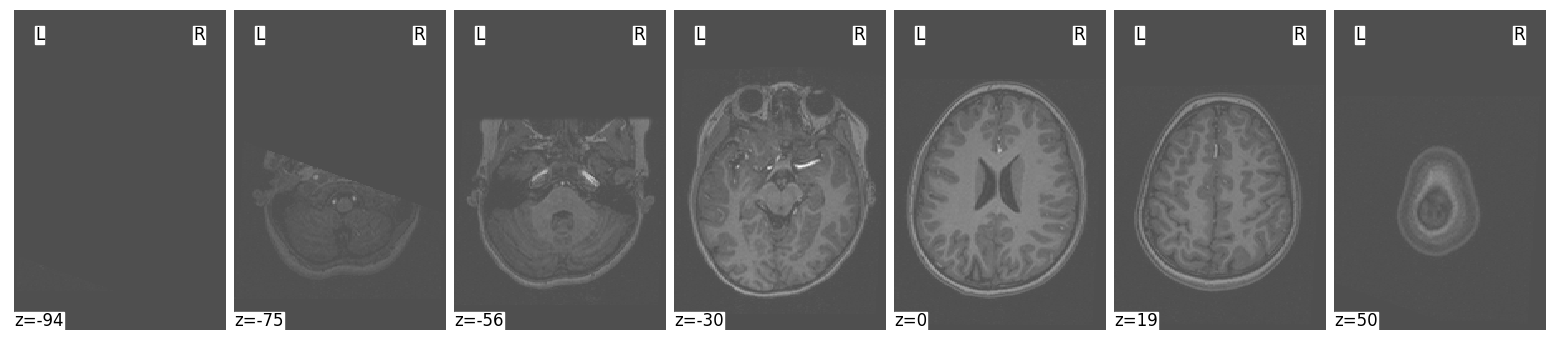

In [ ]:
t1_img = nib.load(op.join(data_dir, "sub-0051121_T1w.nii.gz"))


plotting.plot_anat(t1_img, display_mode= "z", black_bg = False)
plt.show()

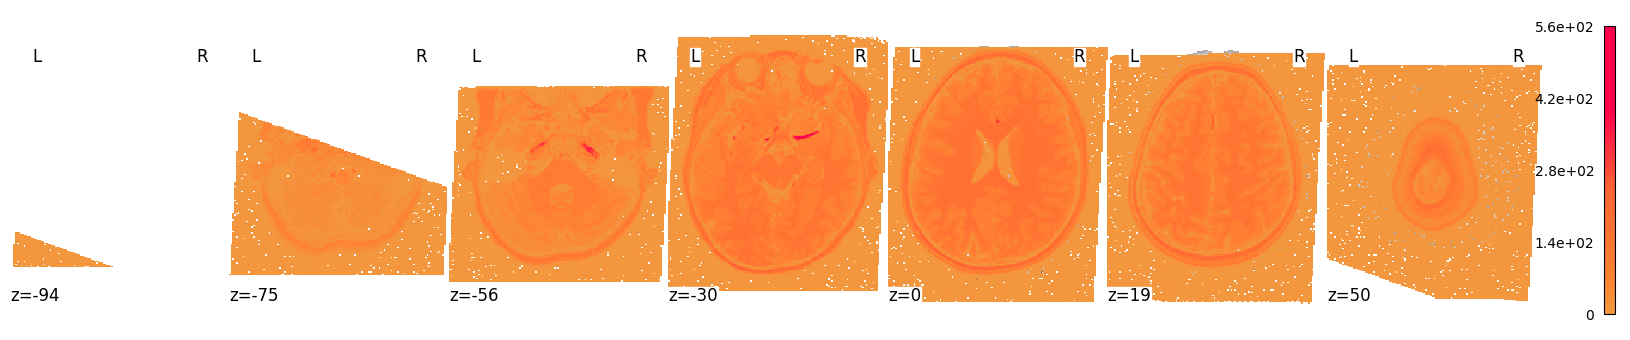

In [ ]:
func_img = nib.load(op.join(data_dir, "sub-0051121_T1w.nii.gz"))
template = datasets.load_mni152_template(resolution=1)

plot_stat_map(
    func_img,
    display_mode= "z",
    bg_img=template,
    black_bg=False,
    draw_cross=False,
    annotate=True,
    cmap=cmap,  # Adjusted dimming factor
)